# Import Libraries

In [1]:
import tensorflow as tf
import pandas as pd
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import os


from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import regularizers

# Image Augmentation

In [2]:
def train_val_generators(TRAINING_DIR, TESTING_DIR):
    train_datagen = ImageDataGenerator(rescale=1./255,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest'
                                      )
    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                        batch_size=15,
                                                       class_mode='categorical',
                                                       target_size=(224,224))
    
    validation_datagen = ImageDataGenerator(rescale=1./255)
    validation_generator = validation_datagen.flow_from_directory(directory=TESTING_DIR,
                                                                  batch_size=15,
                                                                 class_mode='categorical',
                                                                 target_size=(224, 224))
    
    return train_generator, validation_generator

In [3]:
TRAINING_DIR = "../ROBOTSDATASET/training/"
TESTING_DIR = "../ROBOTSDATASET/testing/"
train_generator, validation_generator = train_val_generators(TRAINING_DIR, TESTING_DIR)

Found 8013 images belonging to 19 classes.
Found 900 images belonging to 19 classes.


# InceptionV3

In [4]:
# Set the weights file you downloaded into a variable
local_weights_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model_inception = InceptionV3(input_shape = (224, 224, 3), 
                                include_top = False, 
                                weights = None,
                                             )

pre = InceptionV3
# Load the pre-trained weights you downloaded.
pre_trained_model_inception.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model_inception.layers:
    layer.trainable = False

In [5]:
pre_trained_model_inception.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

 batch_normalization_5 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 25, 25, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 25, 25, 32)  96          ['conv2d_11[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_22 (BatchN  (None, 25, 25, 64)  192         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 25, 25, 64)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 25, 25, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 25, 25, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 12, 12, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 12, 12, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_34 (Conv2D)             (None, 12, 12, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 12, 12, 128)  384        ['conv2d_34[0][0]']              
 ormalizat

                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_44 (Conv2D)             (None, 12, 12, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 12, 12, 160)  480        ['conv2d_44[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 12, 12, 160)  179200      ['activation_44[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_54[0][0]'] 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 12, 12, 160)  179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_55 (BatchN  (None, 12, 12, 160)  480        ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_55[0][0]'] 
          

                                                                                                  
 batch_normalization_65 (BatchN  (None, 12, 12, 192)  576        ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 12, 12, 192)  0           ['batch_normalization_65[0][0]'] 
                                                                                                  
 conv2d_61 (Conv2D)             (None, 12, 12, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 12, 12, 192)  258048      ['activation_65[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_70 (Conv2D)             (None, 12, 12, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 12, 12, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_normalization_70 (BatchN  (None, 12, 12, 192)  576        ['conv2d_70[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 12, 12, 192)  576        ['conv2d_74[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_76 (BatchN  (None, 5, 5, 320)   960         ['conv2d_76[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_78[0][0]'] 
                                                                                                  
 activation_79 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_79[0][0]'] 
                                                                                                  
 activation_82 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_83[0][0]'] 
          

                                                                                                  
 activation_91 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_91[0][0]'] 
                                                                                                  
 activation_92 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_92[0][0]'] 
                                                                                                  
 batch_normalization_93 (BatchN  (None, 5, 5, 192)   576         ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 5, 5, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 

In [6]:
# Choose `mixed_7` as the last layer of your base model
last_layer = pre_trained_model_inception.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 12, 12, 768)


In [7]:
# Flatten the output layer to 1 dimension

x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dropout(0.2)(x) 
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = tf.keras.layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = tf.keras.layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = tf.keras.layers.Dense  (19, kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)           

# Append the dense network to the base model
model_4 = Model(pre_trained_model_inception.input, x) 

model_4.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

 batch_normalization_5 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 25, 25, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 25, 25, 32)  96          ['conv2d_11[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_22 (BatchN  (None, 25, 25, 64)  192         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 25, 25, 64)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 25, 25, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 25, 25, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 12, 12, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 12, 12, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_34 (Conv2D)             (None, 12, 12, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 12, 12, 128)  384        ['conv2d_34[0][0]']              
 ormalizat

                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_44 (Conv2D)             (None, 12, 12, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 12, 12, 160)  480        ['conv2d_44[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 12, 12, 160)  179200      ['activation_44[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_54[0][0]'] 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 12, 12, 160)  179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_55 (BatchN  (None, 12, 12, 160)  480        ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_55[0][0]'] 
          

                                                                                                  
 batch_normalization_65 (BatchN  (None, 12, 12, 192)  576        ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 12, 12, 192)  0           ['batch_normalization_65[0][0]'] 
                                                                                                  
 conv2d_61 (Conv2D)             (None, 12, 12, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 12, 12, 192)  258048      ['activation_65[0][0]']          
                                                                                                  
 batch_nor

In [8]:
model_4.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [9]:
# Train the model.
history_4 = model_4.fit(
            train_generator,
            validation_data = validation_generator,
            epochs = 50,
            )

Epoch 1/50
535/535 [==============================] - 1251s 2s/step - loss: 1.9170 - accuracy: 0.4570 - val_loss: 1.1375 - val_accuracy: 0.6544
Epoch 2/50
535/535 [==============================] - 1248s 2s/step - loss: 1.2966 - accuracy: 0.6205 - val_loss: 1.0275 - val_accuracy: 0.6767
Epoch 3/50
535/535 [==============================] - 1302s 2s/step - loss: 1.1649 - accuracy: 0.6577 - val_loss: 0.9401 - val_accuracy: 0.7089
Epoch 4/50
535/535 [==============================] - 1279s 2s/step - loss: 1.0769 - accuracy: 0.6786 - val_loss: 0.9618 - val_accuracy: 0.7200
Epoch 5/50
535/535 [==============================] - 1281s 2s/step - loss: 1.0108 - accuracy: 0.7024 - val_loss: 0.9731 - val_accuracy: 0.7289
Epoch 6/50
535/535 [==============================] - 1262s 2s/step - loss: 0.9753 - accuracy: 0.7125 - val_loss: 0.9104 - val_accuracy: 0.7356
Epoch 7/50
535/535 [==============================] - 1266s 2s/step - loss: 0.9297 - accuracy: 0.7261 - val_loss: 0.8740 - val_accuracy:

KeyboardInterrupt: 

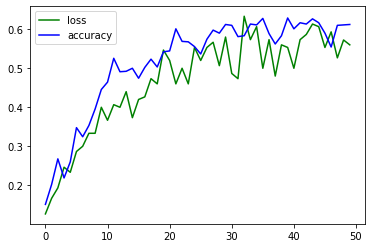

In [136]:
plt.plot(history_4.history['accuracy'], color='g')
plt.plot(history_4.history['val_accuracy'], color='b')
plt.legend(history_4.history)

# Evaluating all model performance

# Testing Prediction

In [79]:
train_generator.class_indices

{'abyssinian': 0,
 'bengal': 1,
 'birman': 2,
 'bombay': 3,
 'british_shorthair': 4,
 'calico': 5,
 'dilute_calico': 6,
 'domestic_long_hair': 7,
 'egyptian_mau': 8,
 'himalayan': 9,
 'maine_coon': 10,
 'persian': 11,
 'ragdoll': 12,
 'russian_blue': 13,
 'scottish_fold': 14,
 'siamese': 15,
 'sphynx': 16,
 'turkish_angora': 17,
 'tuxedo': 18}

In [80]:
list_of_class = [key for  key,value in train_generator.class_indices.items()]
list_of_class

['abyssinian',
 'bengal',
 'birman',
 'bombay',
 'british_shorthair',
 'calico',
 'dilute_calico',
 'domestic_long_hair',
 'egyptian_mau',
 'himalayan',
 'maine_coon',
 'persian',
 'ragdoll',
 'russian_blue',
 'scottish_fold',
 'siamese',
 'sphynx',
 'turkish_angora',
 'tuxedo']

In [5]:
# Load in the SavedModel format
saved_model = tf.keras.models.load_model('model_4_robots_balanced_20')

Predicted:  dilute_calico
Real:  dilute_calico


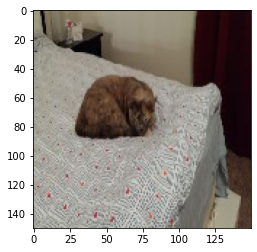

In [78]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import random
import os

class_name = "dilute_calico"
random_image = random.sample(os.listdir(f'../ROBOTSDATASET/testing/{class_name}/'), 1)
img_path = f"../ROBOTSDATASET/testing/{class_name}/" + random_image[0]
img = image.load_img(img_path, target_size=(150, 150))
x = image.img_to_array(img)
x = x/255.
x = np.expand_dims(x, axis=0)
print("Predicted: " , list_of_class[np.argmax(saved_model.predict(x))])
print("Real: ", class_name)
plt.imshow(img)



# Saving the model and convert into TFLite

In [19]:
# Select mode of optimization
mode = "Speed" 

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [20]:
export_dir = 'model_2'
tf.saved_model.save(model_4, export_dir)

INFO:tensorflow:Assets written to: model_2\assets


In [21]:

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

# Set the optimzations
converter.optimizations = [optimization]

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert()

In [22]:
tflite_model_file = pathlib.Path('model_2.tflite')
tflite_model_file.write_bytes(tflite_model)

47777616

In [23]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()



In [24]:
import os

with open('labels.txt', 'w') as f:
    for label in os.listdir('../ROBOTSDATASET/training/'):
        f.writelines(f'{label}\n')